In [49]:
# Libraries for handling the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For preparing the data to use in LSTM  
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor

In [50]:
# Loading datasets 
# Note: csv files can be found on pCloud
Science1900_2023 = pd.read_csv('./data/Science1900_2023.csv', index_col=0)  
topic_proba_data_Science1900_2023 = pd.read_csv('./data/topic_proba_data_Science1900_2023.csv',index_col=0)  

topified_vectorized_Science1900_2023 = pd.read_csv('./data/topified_vectorized_Science1900_2023.csv', index_col=0)  
topified_vectorized_Science1900_2023['fieldsOfStudy']= Science1900_2023['fieldsOfStudy']
topified_vectorized_Science1900_2023['s2FieldsOfStudy']= Science1900_2023['s2FieldsOfStudy']
topified_vectorized_Science1900_2023 = topified_vectorized_Science1900_2023.drop(['title','abstract','paperId','externalIds', 'publicationVenue', 'publicationTypes'], axis=1)
topified_vectorized_Science1900_2023['publicationDate'] = pd.to_datetime(topified_vectorized_Science1900_2023['publicationDate']) 
topified_vectorized_Science1900_2023['year'] = pd.to_datetime(topified_vectorized_Science1900_2023['year'], format ='%Y') 

topic_labels_df = pd.read_csv('./data/topic_labels.csv')

In [51]:
# Extracting/Creating single topics

# Variables:
look_back = 20
neurons=4
epochs=20

scaler_for_citation_count = MinMaxScaler(feature_range=(0, 1))
scaler_for_cumulative_citation_count = MinMaxScaler(feature_range=(0, 1))
grouped_by_all_topics = topified_vectorized_Science1900_2023.groupby('topic_code')

# Getting the first topic from the group
topic_0_df = grouped_by_all_topics.get_group(0)
topic_0_df['publicationDate'].fillna(topic_0_df['year'].apply(lambda x:x), inplace=True)
topic_0_df.drop('year', axis=1,inplace=True)
topic_0_df= topic_0_df.groupby('publicationDate').sum('citationCount')
topic_0_df['cumulative_citationCount'] = topic_0_df['citationCount'].cumsum()
topic_0_df['citationCount_scaled'] = scaler_for_citation_count.fit_transform(topic_0_df[['citationCount']])
topic_0_df['cumulative_citationCount_scaled'] = scaler_for_cumulative_citation_count.fit_transform(topic_0_df[['cumulative_citationCount']])

#train / test split
train_data = topic_0_df.query('publicationDate <  "2015-01-01"').reset_index(drop = False) 
test_data  = topic_0_df.query('publicationDate >= "2015-01-01"').reset_index(drop = False)


/tmp/ipykernel_5865/3710033661.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_0_df['publicationDate'].fillna(topic_0_df['year'].apply(lambda x:x), inplace=True)
/tmp/ipykernel_5865/3710033661.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_0_df.drop('year', axis=1,inplace=True)


In [52]:
# Training the LSTM - time series for a single topic
n_features = 1

X_train = train_data.publicationDate
y_train = train_data['citationCount_scaled']

X_test = test_data.publicationDate
y_test = test_data['citationCount_scaled']

train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(neurons,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(neurons))
model.add(Dropout(0.2))
model.add(Dense(1))  # Modify the output layer as needed
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_generator, epochs=epochs,verbose=0)

test_predictions  = model.predict(test_generator)

# uncomment to undo the scaling
test_predictions_citation_count = scaler_for_citation_count.inverse_transform(test_predictions)

18/18 [==============================] - 2s 11ms/step


Text(0.5, 1.0, 'Citation Count Prediction')

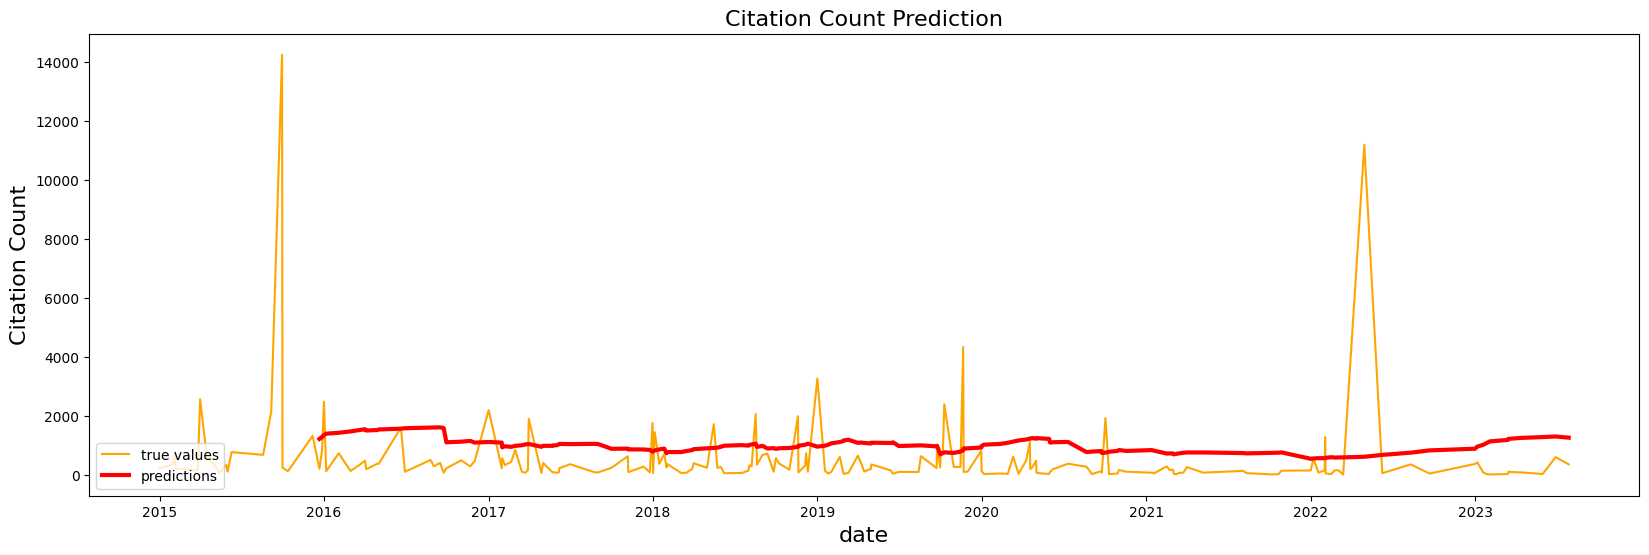

In [53]:
# Citation Count prediction for a single topic
plt.figure(figsize=(20,6))
plt.plot(test_data.publicationDate, test_data['citationCount'], c='orange',label='true values')
plt.plot(X_test[20:],test_predictions_citation_count, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Citation Count", fontsize=16)
plt.title("Citation Count Prediction", fontsize=16)

In [54]:
# Cumulative Citation Count
# Variables:
look_back = 20
epochs=20
neurons=4

X_train = train_data.publicationDate
y_train = train_data['cumulative_citationCount_scaled']

X_test = test_data.publicationDate
y_test = test_data['cumulative_citationCount_scaled']

n_features = 1

train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(neurons,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(neurons))
model.add(Dropout(0.2))                    
model.add(Dense(1))  # Modify the output layer as needed
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_generator, epochs=epochs,verbose=0)
test_predictions  = model.predict(test_generator)
test_predictions_cumulative_citation_count = scaler_for_cumulative_citation_count.inverse_transform(test_predictions)

18/18 [==============================] - 2s 14ms/step


Text(0.5, 1.0, 'Citation Count Prediction')

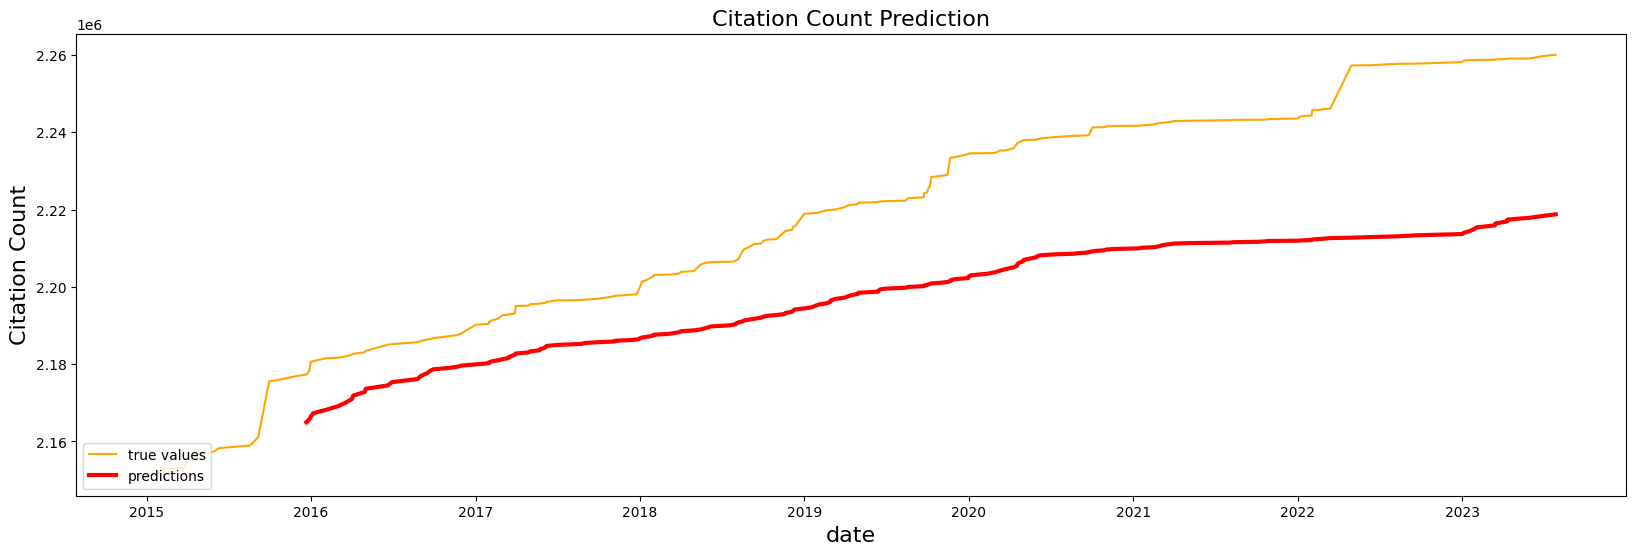

In [64]:
plt.figure(figsize=(20,6))
plt.plot(test_data.publicationDate, test_data['cumulative_citationCount'], c='orange',label='true values')
plt.plot(X_test[look_back:],test_predictions_cumulative_citation_count, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Citation Count", fontsize=16)
plt.title("Citation Count Prediction", fontsize=16)

Text(0.5, 1.0, 'Citation Count Prediction')

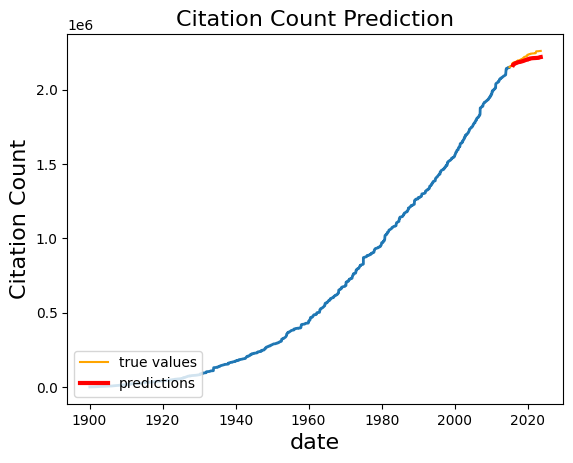

In [65]:
plt.plot(train_data.publicationDate, train_data['cumulative_citationCount'], lw=2)
plt.plot(test_data.publicationDate, test_data['cumulative_citationCount'], c='orange',label='true values')
plt.plot(X_test[look_back:],test_predictions_cumulative_citation_count, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Citation Count", fontsize=16)
plt.title("Citation Count Prediction", fontsize=16)


In [66]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_data['cumulative_citationCount'].iloc[20:],test_predictions_cumulative_citation_count,squared=False)
rmse

25605.254015194063

: 